# Introduction

> I will use PreTrained Model Inception Netowrk to train my model. Off Course because we need to go deeper :)

![](https://miro.medium.com/max/1656/1*uW81y16b-ptBDV8SIT1beQ.png)

Inceptionv3 is a convolutional neural network for assisting in image analysis and object detection, and got its start as a module for Googlenet. It is the third edition of Google's Inception Convolutional Neural Network, originally introduced during the ImageNet Recognition Challenge. Just as ImageNet can be thought of as a database of classified visual objects, Inception helps classification of objects in the world of computer vision. One such use is in life sciences, where it aids in the research of Leukemia. It was "codenamed 'Inception' after the film of the same name"

In [43]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os

from tensorflow.keras import layers
from tensorflow.keras import Model

In [44]:
rock_dir = os.path.join('../input/rock-paper-scissor/rps/rps/rock')
paper_dir = os.path.join('../input/rock-paper-scissor/rps/rps/paper')
scissors_dir = os.path.join('../input/rock-paper-scissor/rps/rps/scissors')

print('Total training rock images:', len(os.listdir(rock_dir)))
print('\nTotal training paper images:', len(os.listdir(paper_dir)))
print('\nTotal training scissors images:', len(os.listdir(scissors_dir)))

Total training rock images: 840

Total training paper images: 840

Total training scissors images: 840


In [46]:
rock_files = os.listdir(rock_dir)
print("Some Rock File Names\n", rock_files[:5])

paper_files = os.listdir(paper_dir)
print("\nSome Paper File Names\n",paper_files[:5])

scissors_files = os.listdir(scissors_dir)
print("\nSome Scissor File Names\n",scissors_files[:5])

Some Rock File Names
 ['rock05ck01-066.png', 'rock05ck01-026.png', 'rock06ck02-040.png', 'rock04-016.png', 'rock06ck02-084.png']

Some Paper File Names
 ['paper07-084.png', 'paper04-062.png', 'paper01-027.png', 'paper02-026.png', 'paper07-072.png']

Some Scissor File Names
 ['testscissors01-066.png', 'testscissors01-050.png', 'testscissors02-076.png', 'testscissors03-000.png', 'testscissors01-102.png']


> Let us see few images :)

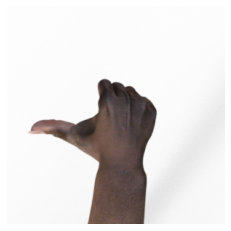

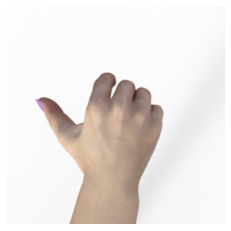

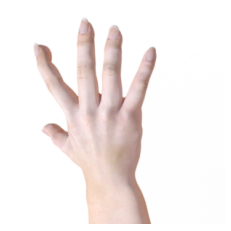

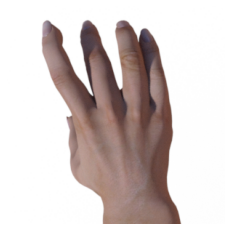

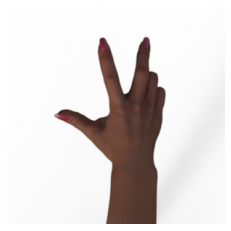

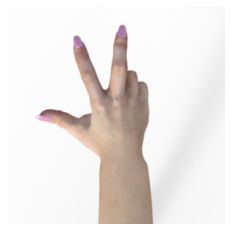

In [47]:
import matplotlib.image as mpimg

pic_index = 3

next_rock = [os.path.join(rock_dir, fname) 
                for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) 
                for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()

# Image Preprocessing

I will use ImageDataGenerator to make it easier to work with images on the go as well as i will also use Data Augmentation.

In [48]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

In [49]:
TRAINING_DIR = "../input/rock-paper-scissor/rps/rps/"
training_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

VALIDATION_DIR = "../input/rock-paper-scissor/rps-test-set/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150,150),
    class_mode='categorical',
  batch_size=100
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    class_mode='categorical',
    batch_size=50
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


# Inception V3

Let us load Inception V3 Pre-trained model.

In [50]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

--2020-06-12 11:34:03--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.128, 2607:f8b0:400c:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   192MB/s    in 0.4s    

2020-06-12 11:34:04 (192 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



> I am using 'mixed7' as last layer from Inception network and i am freezing layers to not retrain them.

**Use summery() to see layers.**

In [52]:
#pre_trained_model_tra.summary()

In [51]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


# DNN Model

Let us add our own model at last layer of Inception.

In [57]:
from tensorflow.keras.optimizers import RMSprop
adam = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (3, activation='softmax')(x)        

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = adam, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [58]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 25,
            epochs = 10,
            validation_steps = 10,
            verbose = 1)

Epoch 1/10
25/25 [==============================] - 24s 963ms/step - loss: 1.9840 - accuracy: 0.7636 - val_loss: 0.8919 - val_accuracy: 0.7204
Epoch 2/10
25/25 [==============================] - 23s 927ms/step - loss: 0.1153 - accuracy: 0.9665 - val_loss: 0.2470 - val_accuracy: 0.9005
Epoch 3/10
25/25 [==============================] - 22s 897ms/step - loss: 0.0613 - accuracy: 0.9760 - val_loss: 0.2963 - val_accuracy: 0.8602
Epoch 4/10
25/25 [==============================] - 23s 918ms/step - loss: 0.0535 - accuracy: 0.9802 - val_loss: 0.1423 - val_accuracy: 0.9409
Epoch 5/10
25/25 [==============================] - 23s 912ms/step - loss: 0.0352 - accuracy: 0.9893 - val_loss: 0.1279 - val_accuracy: 0.9597
Epoch 6/10
25/25 [==============================] - 22s 899ms/step - loss: 0.0327 - accuracy: 0.9888 - val_loss: 0.1886 - val_accuracy: 0.9301
Epoch 7/10
25/25 [==============================] - 23s 923ms/step - loss: 0.0191 - accuracy: 0.9959 - val_loss: 0.2328 - val_accuracy: 0.9274

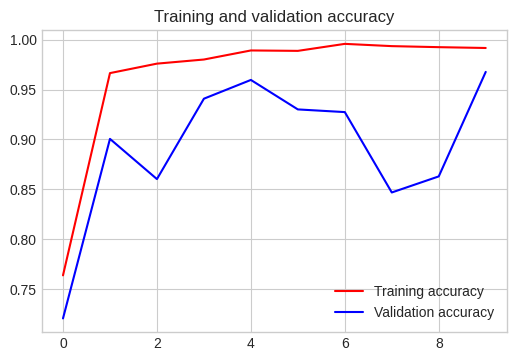

In [62]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.style.use('seaborn-whitegrid')
plt.figure(dpi = 100)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show();

> Do not worry why curve is fluctuating so much, this is because our data is different than what is is in Inception Netowrk. We can try much deeper network to our data to increase accuracy on Validation set. Can you see how good it is doing with adding just one layer after inception. That's the beauty of Transfer Learning.

**Thank you for reading my Notebook. I hope you learned something new. You can try tweaking parameters and play around them.**